## Capture of #WalkTO Tweets

* use twython to invoke the Twitter search api

In [1]:
import json # library to handle JSON files
import numpy as np
import pandas as pd
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import urllib
import matplotlib.pyplot as plt


In [2]:
# pip install twython
from twython import Twython, TwythonError  

#### Setup
* import credentials
* set base query term

In [3]:

# Load credentials from json file
with open("twitter_credentials.json", "r") as file:  
    creds = json.load(file)
# Load credentials from json file
with open("bing_credentials.json", "r") as file:  
    bing_key = json.load(file)


In [4]:
# Instantiate an object
python_tweets = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])


In [5]:
base_query_term = "#VisionZero" #"WalkTO" # term we are searching for
max_iters = 50 # controls how many times we go back to get additional pages

* We can only retrieve up to 100 tweets at a time with the search api, so nest in a for loop to gather more tweets.  NOTE: there is a cursor you can in Twython to loop through all the possible search results ("results = python_tweets.cursor(python_tweets.search, **query)" , but I was getting odd results for it -- it was intermittently failing to retreive certain Tweets
* Tweets > 128 characters were getting cut off due to recent twitter change.  So have to set tweet_mode to extended and grb the "full_text" value rather than just text
* Search index has a 7-day limit - no tweets will be found for a date older than one week.
* Handling of Retweets:
    * the retweeted flag always seems to be false, so a more reliable indicator is the retweet_count.  But it is the same on the original tweet plus all the retweets (i.e. if a tweet was retweeted for times, the four retweets and the original will have a retweet count of 4.  So the safest way to filter out retweets seems to use text filtering for the "RT @" prefix

In [6]:
max_id = ""
dict_ = {'id': [], 'date': [], 'text': [], 'favorite_count': [],'retweet_count': [],'location':[]}  

for call in range(0,max_iters):

    query = {'q': base_query_term,  
        'result_type': 'recent',
        'count': 100,
        'lang': 'en',
         'max_id': max_id, # what tweet id to start retrieving from
        'tweet_mode':'extended',
        'include_entities': False
     }
   

    for status in python_tweets.search(**query)['statuses']:  
        if  'RT @' not in (status['full_text']):
            dict_['id'].append(status['id'])
            # dict_['user'].append(status['user']['screen_name'])
            dict_['date'].append(status['created_at'])
            dict_['text'].append(status['full_text']) # contains text > 128 chars
            dict_['favorite_count'].append(status['favorite_count'])
            dict_['retweet_count'].append(status['retweet_count'])
            dict_['location'].append(status['user']['location'])
            max_id = status['id'] # store last tweet accessed so on next iter we will only grab tweets older than that



In [7]:
# Structure data in a pandas DataFrame for easier manipulation
df = pd.DataFrame(dict_)  
df.sort_values(by='id', inplace=True, ascending=False)  
df.head()

,id,date,text,favorite_count,retweet_count,location
0,1056638453218037760,Sun Oct 28 20:06:53 +0000 2018,And we need to just keep naming/faming and sup...,0,0,Seattle
1,1056634560421650432,Sun Oct 28 19:51:25 +0000 2018,Get your #costumes ready! We will be at @eSIPA...,0,0,"Los Angeles, CA"
2,1056623711976009729,Sun Oct 28 19:08:18 +0000 2018,this morning 👇.\ntwo of the worst #redlightrun...,19,6,"Tāmaki Makaurau, Aotearoa"
3,1056622903272312838,Sun Oct 28 19:05:05 +0000 2018,Have you been in a crash while biking in Belle...,2,0,"Washington, USA"
4,1056620938555482112,Sun Oct 28 18:57:17 +0000 2018,When #VisionZero and #climatejustice takes tru...,0,0,"Oklahoma City, OK"


In [8]:
df.shape

(1110, 6)

In [9]:
df.to_csv('visionzero_tweets2.csv', index=False)

### Tokenize the Tweets
* use the TweetTokenizer to get support for special twitter characters (# and @ symbols have special meanings)

In [10]:
import nltk
nltk.download('stopwords')  # run once
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import TweetTokenizer
import string
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blahjays\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def tweet_preprocessor(line, ret_type = 'string'):
    ''' this function accepts a line of text and attempts to clean it up.  
    It uses the TweetTokenizer to split up the sentence into a list of words, 
        removes stop words, special characters and http urls and forces everyting to lowercase
    If ret_type is string (default), it returns a clean string.  otherwise it returns the list of cleaned words
    '''

    # use the Tweet Tokenizer to get a list of words
    tknzr = TweetTokenizer(preserve_case=False, strip_handles=True)
    word_list=tknzr.tokenize(line.strip().lower())

    # remove stopwords - include English stop words, our defined stop words and strip out http urls
    stops = set(stopwords.words('english'))
    # define a few extra stop words to include
    extra_stops = ['‘','’','rt','…','—','.', ',','-','(',')','&','?','!','$','<','>','/','*',':',':','"']
    meaningful_words = [w for w in word_list if not w in stops and not w.startswith('http') and not w in extra_stops] 
    
     # stem/lmemmatize (look for root words)
    meaningful_words = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    if ret_type =='string':
        return(" ".join(meaningful_words))
    else:
        return meaningful_words

* example use of above function

In [12]:
atweet=df['text'][70]
atweet

"10/2018\n\nEU Transport Commissioner @Bulc_EU announced the appointment of @BaldwinMatthew_ as EU Coordinator for #RoadSafety\n\nI am curious whether the @EU_Commission's understanding of road safety includes save roads too or focuses on cars only #VisionZero\nhttps://t.co/R39uTTa3xq"

In [13]:
atweet=df['text'][70]
tweet_preprocessor(atweet)

"10/2018 eu transport commissioner announced appointment eu coordinator #roadsafety curious whether ' understanding road safety includes save road focus car #visionzero"

* Loop through all our tweets and clean up each one

In [14]:
cleaned_tweets = [tweet_preprocessor(row) for row in df['text']]

In [15]:
cleaned_tweets[0:10]

['need keep naming faming supporting city mayor innovator zero #activetransportation | walk bike #climatechange solution already exists renew #safestreets #visionzero commitment #cities4climate #bikes4climate',
 'get #costumes ready #halloween carnival wednesday #visionzero seeing real #treat 😘 🎃 👻',
 'morning 👇 two worst #redlightrunners seen long time ... [ audi bmw ... quelle suprise ... audi actually accelerating red bmw different planet ... ] 😳 🤬 😤 yeah lime #escooters terrorising #auckland crossing ... 🙄 🤔 #visionzero',
 'crash biking bellevue part #visionzero planning franz loewenherz want hear story share email floewenherz@bellevuewa.gov',
 '#visionzero #climatejustice take true action',
 'please get enforcement front tim hortons bay gerrard car constantly blocking bike lane stopping stopping zone #visionzero #biketo',
 'two classic steel mtbs carrying two brother turn brooklyn #trueblue riding support #visionzero #climatejustice lgbtq right #bikenyc much',
 'day feel like twit

## Vectorizing
* So now that we have a fairly clean and simplified version of our Tweets, we might want to Vectorize the results in order to extract the most commonly used words or to feed the Tweets to a clustering algorithm. 
* With basic count vectorization, we create a very sparse matrix where the columns are all the individual words appearing anywhere in our collection of Tweets (the "corpus") and the rows are the individual tweets. So if our first tweet only contained two words ("pedestrian" and "safety"), row one would have zeros in all columns except the Pedestrian and Safety columns. This is called a "bag of words" and is only concerned with whether a word appears or not in the next and ignores things like positioning, emphasis, weighting etc. appears in our first tweet, there will be a "1" inVectorization is the process of turning text into numeric
* I used the basic CountVectorizer to create a feature vector with a frequency score for each word in a Tweet. 
* The token_pattern tells it to preserve the hashtags (#) in the tweets (credit to the examples page on ProgramCreek for the regex) (https://www.programcreek.com/python/example/83254/sklearn.feature_extraction.text.TfidfVectorizer)


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
#remove mentions but keep hashtags with their sign
token_pattern = r'(?u)(?<![@])#?\b\w\w+\b'
cvec = CountVectorizer(stop_words='english',token_pattern=token_pattern)

In [18]:
cvec.fit(cleaned_tweets)
X_train_counts=cvec.transform(cleaned_tweets)

In [19]:
len(cvec.get_feature_names())

4470

* create a data frame

In [20]:
all_tweets_df = pd.DataFrame(X_train_counts.toarray(), columns=cvec.get_feature_names())
all_tweets_df.sample(5)

,#104pct,#20isplenty,#2deathsaretoomany,#30km,#3es,#880str,#8to80,#abbiegeassistent,#ableg,#abq,...,ytd,yukon,yup,zebra,zeolots,zero,zing,zone,zoo,zoë
950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* create a Series with the top 100 most important words and convert to a dataframe

In [21]:
top_words = all_tweets_df.sum().sort_values(ascending=False).iloc[1:100]
top_words=top_words.to_frame()
top_words=top_words.reset_index().rename(columns={'index': 'word', 0:'freq'})
top_words.head(10)

,word,freq
0,driver,236
1,bike,234
2,lane,199
3,#bikenyc,161
4,community,153
5,safety,146
6,near,135
7,board,131
8,october,130
9,reported,128


## Create a WordCloud visualization of top terms in the WalkTO Tweets

* use WordCloud Module

In [22]:
#pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

* wordcloud accepts a dictionary where the key is the word and the value is the number of times it appears
* so we'll convert our dataframe with the top 100 words to a dictionary

In [23]:
freq_dict = top_words.set_index('word').to_dict()['freq']

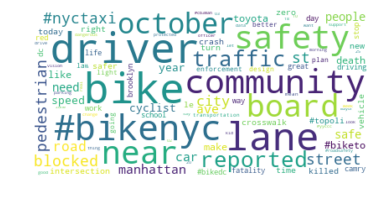

In [24]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(freq_dict)
plt.figure()

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Word2Vec
* use gensim

In [25]:
import gensim
from gensim.models.word2vec import Word2Vec

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [26]:
list_tweets = []
for tweet in cleaned_tweets:
    list_tweets.append(tweet_preprocessor(tweet, 'list'))

Required format for sentences


* sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
	['this', 'is', 'the', 'second', 'sentence'],
	['yet', 'another', 'sentence'],
	['one', 'more', 'sentence'],
	['and', 'the', 'final', 'sentence']]

In [27]:
list_tweets[0:5]

[['need',
  'keep',
  'naming',
  'faming',
  'supporting',
  'city',
  'mayor',
  'innovator',
  'zero',
  '#activetransportation',
  '|',
  'walk',
  'bike',
  '#climatechange',
  'solution',
  'already',
  'exists',
  'renew',
  '#safestreets',
  '#visionzero',
  'commitment',
  '#cities4climate',
  '#bikes4climate'],
 ['get',
  '#costumes',
  'ready',
  '#halloween',
  'carnival',
  'wednesday',
  '#visionzero',
  'seeing',
  'real',
  '#treat',
  '😘',
  '🎃',
  '👻'],
 ['morning',
  '👇',
  'two',
  'worst',
  '#redlightrunners',
  'seen',
  'long',
  'time',
  '...',
  '[',
  'audi',
  'bmw',
  '...',
  'quelle',
  'suprise',
  '...',
  'audi',
  'actually',
  'accelerating',
  'red',
  'bmw',
  'different',
  'planet',
  '...',
  ']',
  '😳',
  '🤬',
  '😤',
  'yeah',
  'lime',
  '#escooters',
  'terrorising',
  '#auckland',
  'crossing',
  '...',
  '🙄',
  '🤔',
  '#visionzero'],
 ['crash',
  'biking',
  'bellevue',
  'part',
  '#visionzero',
  'planning',
  'franz',
  'loewenherz',
  

In [28]:
# Train Word2Vec model. Defaults result vector size = 100
#So, we are essentially passing on a list of lists. 
#Where each list within the main list contains a set of tokens from a user review

model = Word2Vec(list_tweets, min_count = 0, workers=2)
model.train(list_tweets, total_examples=len(list_tweets), epochs=10)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


(170538, 194130)

In [29]:
# check model for a word
model.corpus_total_words

19413

In [30]:
# summarize vocabulary
words = list(model.wv.vocab)
words[0:10]

['need',
 'keep',
 'naming',
 'faming',
 'supporting',
 'city',
 'mayor',
 'innovator',
 'zero',
 '#activetransportation']

In [31]:
model['crossing']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.34381628,  0.34937838,  0.22880763,  0.06766599, -0.6848655 ,
       -0.31537262,  0.5267218 , -0.39520398, -0.3982092 ,  0.29719904,
       -0.22102027, -0.04151562,  0.44758815, -0.17968434,  0.26335636,
        0.02177299,  0.44009992,  0.10987701, -0.30469805,  0.2928268 ,
       -0.51748145, -0.09147996,  0.08574892,  0.13559751, -0.1936442 ,
       -0.3726492 , -0.55854976, -0.0586527 ,  0.22047625, -0.13211738,
        0.4916753 , -0.17157733,  0.12774034,  0.10526374,  0.00872502,
        0.10967977,  0.3103287 , -0.46569204,  0.08341961, -0.44333848,
        0.32651177, -0.12577015, -0.30250037,  0.4606381 , -0.25243014,
       -0.0758742 , -0.19011088,  0.4240496 , -0.10797154,  0.3006354 ,
       -0.2687077 , -0.02604207, -0.33184806, -0.10785183, -0.08324189,
        0.15548272,  0.2037157 , -0.21513908,  0.48433876, -0.33243847,
       -0.2603298 , -0.1533459 , -0.01080013, -0.12266141,  0.20878485,
       -0.19406147, -0.21155994,  0.36828455, -0.3168834 , -0.26

In [32]:
model.most_similar('trail')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('around', 0.9998886585235596),
 ('also', 0.9998844861984253),
 ('officer', 0.999867856502533),
 ('help', 0.9998664259910583),
 ('thanks', 0.9998661875724792),
 ('want', 0.9998660087585449),
 ('police', 0.9998610019683838),
 ('since', 0.9998596906661987),
 ('neighborhood', 0.9998544454574585),
 ('let', 0.9998485445976257)]

In [33]:
model.similar_by_word('accident')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('killed', 0.9997137188911438),
 ('people', 0.9996294975280762),
 ('death', 0.999611496925354),
 ('design', 0.9995982646942139),
 ('right', 0.9995765686035156),
 ('walking', 0.9995670914649963),
 ('every', 0.9995614290237427),
 ('road', 0.9995512962341309),
 ('speed', 0.999535858631134),
 ('protect', 0.9995259046554565)]

In [34]:
model.similar_by_word('pedestrian')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('killed', 0.9998244643211365),
 ('speed', 0.9998199939727783),
 ('design', 0.9998155832290649),
 ('road', 0.9998102188110352),
 ('traffic', 0.9998087882995605),
 ('every', 0.9998048543930054),
 ('intersection', 0.9997996687889099),
 ('one', 0.9997982382774353),
 ('fatality', 0.9997917413711548),
 ('street', 0.9997905492782593)]

In [35]:
model.wv.doesnt_match("bike trail orange cycle".split())

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'bike'

### Try to visualize the learned relationships
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa

In [36]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['safety','pedestrian','bike','police','traffic']}
similar_words

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'safety': ['...', 'city', 'work', 'change', 'must'],
 'pedestrian': ['killed', 'speed', 'design', 'road', 'traffic'],
 'bike': ['lane', 'l', 'blocked', 'driver', 'base'],
 'police': ['officer', 'drive', 'response', 'also', 'neighborhood'],
 'traffic': ['road', 'fatality', 'serious', 'death', 'safer']}

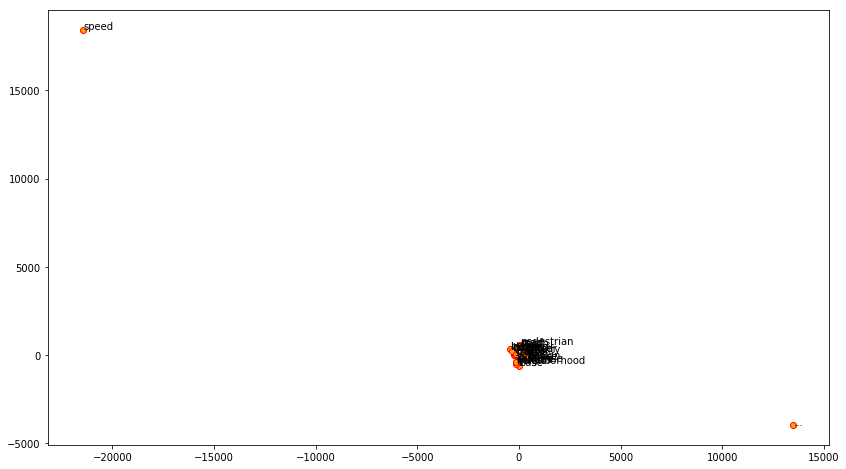

In [37]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# Summarization

In [38]:
from gensim.summarization import summarize, keywords

In [39]:

walkto_doc = ". ".join((tweet for tweet in cleaned_tweets))


In [40]:
summarize(walkto_doc, word_count=20)

'toyota camry hybrid driver t642493c blocked bike lane near 1066 st nicholas ave october 23 reported #nyctaxi manhattan community board 12 #mancb12 #nypd33pct #visionzero #bikenyc.'

# Sentiment Analysis using Textblob



In [41]:
# pip install textblob
# download corpora python -m textblob.download_corpora

In [42]:
from textblob import TextBlob 


In [44]:
 # create TextBlob object of passed tweet text 
def get_sentiment(tweet):
    analysis = TextBlob(tweet) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'
  

In [45]:
pd.set_option('display.max_colwidth', -1)

In [46]:
tweet_sentiments= [ get_sentiment(tweet) for tweet in cleaned_tweets]

In [47]:
sentiment_dict = {'tweet': cleaned_tweets,
                 'sentiment': tweet_sentiments}

tweet_sentiments_df = pd.DataFrame(sentiment_dict)

In [48]:
tweet_sentiments_df.sample(10)

,tweet,sentiment
749,toyota prius driver t653965c drove aggressively near 975 st nicholas ave october 19 reported #nyctaxi manhattan community board 12 #mancb12 #nypd33pct #visionzero #bikenyc,positive
562,#visionzero news across potomac #visionzerodc #bikedc #walkdc,neutral
690,strong call #visionzero vision #brum know many people across birmingham would support call ...,positive
871,#asthma #copd emphysema suffering #visionzero,neutral
502,met someone tonight always considered super cool cyclist learned gave suck bike around city--the collision anger ... awful #biketo #visionzero,negative
1045,one favorite thing #portland #protectedbikelanes please cc #saferstreets #visionzero,positive
1011,lincoln town car executive driver t603449c blocked bike lane near 118 e 106th st october 18 reported #nyctaxi manhattan community board 11 #manhattancb11 #nypd23pct #visionzero #bikenyc,positive
211,chevrolet suburban 1500 lt driver t652053c blocked bike lane near 534 3rd ave october 25 reported #nyctaxi brooklyn community board 06 #brooklyncb6 #nypd78pct #visionzero #bikenyc,positive
149,dc started #visionzero safety blitz supposed start yesterday thought,neutral
511,toyota camry l driver t743844c blocked crosswalk near 299 e 42nd st october 19 reported #nyctaxi manhattan community board 06 #cbsix #nypd17pct #visionzero #bikenyc,positive


In [55]:
tweet_sentiments_df['sentiment'].value_counts()

positive    582
neutral     300
negative    228
Name: sentiment, dtype: int64

In [52]:
tweet_sentiments_df['sentiment'].value_counts()[0]/len(tweet_sentiments_df['sentiment'])*100

52.43243243243243

In [54]:
tweet_sentiments_df['sentiment'].value_counts()[1]/len(tweet_sentiments_df['sentiment'])*100

27.027027027027028

In [53]:
tweet_sentiments_df['sentiment'].value_counts()[2]/len(tweet_sentiments_df['sentiment'])*100

20.54054054054054